In [1]:
import pandas as pd
import numpy as np
import pickle, time
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, urllib.request
import geopandas as gpd

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": 'computer modern roman'})

In [3]:
def readEurostat(url, name):
    file = name+'.tsv.gz'
    if file not in os.listdir('data'): urllib.request.urlretrieve(url, f"data/{file}")
    try:
        df = pd.read_csv(f'data/{file}', sep="\s*\t\s*",index_col=0, engine="python").replace("^:",np.nan,regex=True).replace("\s[a-z]*$","",regex=True).astype(float)
        df.index = pd.MultiIndex.from_tuples([tuple(x.split(",")) for x in df.index], names=df.index.name.replace("\\","").split(","))    
    except: df = 'bad'
    return df

In [13]:
def makeFrame(eurostat_link, vars_of_interest, download, concat):
    # download indicators
    if concat:
        if download:
            downloads = {indicator:readEurostat(f'{eurostat_link}{indicator}.tsv.gz', indicator) for indicator in vars_of_interest}
            with open('data/downloads.pickle', 'wb') as handle: pickle.dump(downloads, handle)
            print('Download successful')
        else:
            with open('data/downloads.pickle', 'rb') as handle: downloads = pickle.load(handle)
        # concat tables
        table = pd.concat([pd.concat([downloads[table]], keys=[table], names=['file']).unstack(-1) for table in downloads 
                           if (table in vars_of_interest) and (type(downloads[table])!=str)]).T
        # fix index and columns
        table.index = ["_".join(pair) for pair in table.index]
        table.columns = ["-".join(pair) for pair in table.columns]
        table.to_csv('data/concat.csv')
    else:
        table = pd.read_csv('data/concat.csv', index_col=0)
    return table

In [86]:
def getNUTS(rerun, df, nut_codes, vars_of_interest, selection):
    if rerun:
        output = df.loc[(df.index.str[5:].isin(nut_codes))&(df.index.str[:4].astype(int).isin(range(2000,2022))),
                       df.columns[pd.Series([x.split('-')[0] for x in df.columns]).isin(vars_of_interest)]].sort_index().copy()
        output.index = pd.MultiIndex.from_arrays([output.index.str[:4], output.index.str[5:]], names=['year', 'code'])
        output = output.unstack(1).T.dropna(how='all').apply(lambda s: s.loc[~s.isnull()].iloc[-1], axis=1).unstack(0)
        output.to_csv(f'data/{selection}/nuts.csv')
    else: output = pd.read_csv(f'data/{selection}/nuts.csv', index_col=0)
    return output

In [156]:
def getSelection(df, _n): return df.loc[df.index[(df.isna().sum(axis=1)<1500)],df.columns[(df.isna().sum(axis=0)<_n)]].dropna(axis=0)
def doTest(df): return [df.shape] + [sum([var in list(set([x.split('-')[0] for x in df.columns])) for var in objective2vars[obj]]) for obj in objective2vars]
# [[x] + doTest(getSelection(nuts_inclusive, x)) for x in range(5,300,10)]##range(0,10,1)

# Run

## Base

In [6]:
euro = gpd.read_file("/home/boturon/download/NUTS_RG_60M_2021_3035.shp.zip")
nuts2_id = euro[euro.LEVL_CODE==2].NUTS_ID.unique()
codes = pd.read_csv("codes.csv", index_col=0)
link = "https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&downfile=data%2F";

In [9]:
dataset = makeFrame(link, codes.index.unique(), False, False)

In [48]:
objective2vars = {area:codes[codes.area==area].index for area in codes.area.unique()}

## Selections

In [22]:
nuts_geral = getNUTS(False, dataset, nuts2_id, codes.index, 'geral')

In [89]:
nuts_econ = getNUTS(False, dataset, nuts2_id, codes[codes.area=='ECONOMY'].index, 'econ')
nuts_smart = getNUTS(False, dataset, nuts2_id, codes[codes.area=='SMART GROWTH'].index, 'smart')
nuts_inclusive = getNUTS(False, dataset, nuts2_id, codes[codes.area=='INCLUSIVE GROWTH'].index, 'inclusive')
nuts_sustainable = getNUTS(False, dataset, nuts2_id, codes[codes.area=='SUSTAINABLE GROWTH'].index, 'sustainable')

In [95]:
[f"{x}: {len(objective2vars[x])}" for x in objective2vars]

['INCLUSIVE GROWTH: 8',
 'ECONOMY: 13',
 'SMART GROWTH: 24',
 'SUSTAINABLE GROWTH: 3']

In [158]:
[
    [[x] + doTest(getSelection(nuts_geral, x)) for x in [51]],
    [[x] + doTest(getSelection(nuts_econ, x)) for x in [39]],    
    [[x] + doTest(getSelection(nuts_smart, x)) for x in [8]],
    [[x] + doTest(getSelection(nuts_sustainable, x)) for x in [1]],
    [[x] + doTest(getSelection(nuts_inclusive, x)) for x in [121]],
]

[[[51, (149, 1198), 4, 4, 13, 1]],
 [[39, (230, 99), 0, 10, 0, 0]],
 [[8, (301, 480), 0, 0, 13, 0]],
 [[1, (314, 4), 0, 0, 0, 1]],
 [[121, (207, 374), 5, 0, 0, 0]]]

In [187]:
_ = getSelection(nuts_geral, 51); _.to_csv('data/geral/data.csv')
_ = getSelection(nuts_econ, 39); _.to_csv('data/econ/data.csv')
_ = getSelection(nuts_smart, 8); _.to_csv('data/smart/data.csv')
_ = getSelection(nuts_sustainable, 1); _.to_csv('data/sustainable/data.csv')
_ = getSelection(nuts_inclusive, 121); _.to_csv('data/inclusive/data.csv')

# NAs

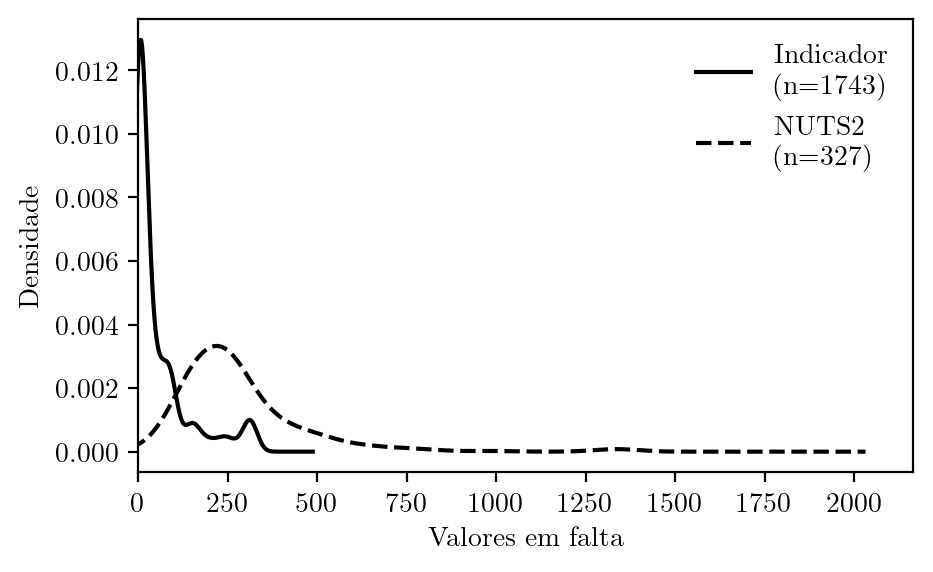

In [182]:
f, ax = plt.subplots(1,1, figsize=(5,3), dpi=200)
nuts_geral.isna().sum().plot.density(ax=ax, c='k', linestyle='-')
nuts_geral.isna().sum(axis=1).plot.density(ax=ax, c='k', linestyle='--')
ax.set_xlim(0); ax.legend([f'Indicador\n(n={nuts_geral.shape[1]})', f'NUTS2\n(n={nuts_geral.shape[0]})'], frameon=False)
ax.set_xlabel('Valores em falta'); ax.set_ylabel('Densidade')

for filetype in ["png","pdf"]: plt.savefig(f'graphs/missing.{filetype}', dpi=200, bbox_inches='tight')
plt.show()

# Vars

In [44]:
codes.reset_index().set_index(['area', 'code']).sort_index()

definition
area               code                                                               
ECONOMY            nama_10_a10       Gross value added and income by A*10 industry ...
                   nama_10_pc                           Main GDP aggregates per capita
                   nama_10r_2coe     Compensation of employees by NUTS 2 regions (n...
                   nama_10r_2emhrw   Employment (thousand hours worked) by NUTS 2 r...
                   nama_10r_2gdp     Gross domestic product (GDP) at current market...
                   nama_10r_2gfcf    Gross fixed capital formation by NUTS 2 region...
                   nama_10r_2gvagr   Real growth rate of regional gross value added...
                   nama_10r_2hhinc   Income of households by NUTS 2 regions (nama_1...
                   nama_10r_2hhinc              Income of households by NUTS 2 regions
                   nama_10r_3gva     Gross value added at basic prices by NUTS 3 re...
                   nasa_10_nf_tr                            Non-financial transactions
                   tgs00004          Regional Gross Domestic Product in Purchasing ...
                   tgs00005          Regional Gross Domestic Product in Purchasing ...
INCLUSIVE GROWTH   demo_r_find2      Fertility indicators by NUTS 2 region (demo_r_...
                   demo_r_mlifexp    Life expectancy by age, sex and NUTS 2 region ...
                   demo_r_pjangroup  Population on 1 January by age group, sex and ...
                   demo_r_pjanind2   Population structure indicators by NUTS 2 regi...
                   tgs00103                                    At-risk-of poverty rate
                   tgs00104                           Severe material deprivation rate
                   tgs00107              People at risk of poverty or social exclusion
                   tgs00108          People living in households with very low work...
SMART GROWTH       edat_lfse_04      Population by educational attainment level, se...
                   edat_lfse_04             Educational level of population aged 25-64
                   edat_lfse_12             Educational level of population aged 30-34
                   edat_lfse_16      Early leavers from education and training by s...
                   edat_lfse_16              Early leavers from education and training
                   edat_lfse_22      Young people neither in employment nor in educ...
                   edat_lfse_33      Employment rates of young people not in educat...
                   lfst_r_edatd_16   Regional disparities in the rate of early leav...
                   lfst_r_edatd_22   Regional disparities in the rate of young peop...
                   lfst_r_lfe2ehour  Average number of usual weekly hours of work i...
                   lfst_r_lfe2emprt  Employment rates by sex, age and NUTS 2 region...
                   lfst_r_lfp2actrt  Economic activity rates by sex, age and NUTS 2...
                   lfst_r_lfsd2pop                                   Population by age
                   lfst_r_lfu2ltu    Long-term unemployment (12 months and more) by...
                   lfst_r_lfu3rt     Unemployment rates by sex, age, educational at...
                   lfst_r_lmder      Regional disparities in employment rates (NUTS...
                   lfst_r_lmdgeg     Regional disparities in gender employment gap ...
                   lfst_r_lmdltu     Regional disparities in long-term unemployment...
                   lfst_r_lmdur      Regional disparities in unemployment rates (NU...
                   nama_10_a10_e               Employment by A*10 industry breakdowns 
                   nama_10_pe                                Population and employment
                   tgs00040          Patent applications to the European Patent Off...
                   tgs00042          Research & Experimental Development expenditur...
                   tgs00109          Tertiary educational attainment by se